In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import math
import matplotlib
import os
import re

from collections import defaultdict
from sklearn.metrics import f1_score
from utils import *
from clustering import *
from classification import *

# set random seed for reproducibility of results
random.seed(42)

In [3]:
import sklearn

In [4]:
print(sklearn.__version__)

0.21.2


In [2]:
PATH = os.getcwd() + "\\data\\"
file = os.path.join(PATH, os.listdir(PATH)[0])
data = pd.read_csv(file, sep=';')

In [3]:
data.rename(columns={'Timestamp':'timestamp',
                     'Your mean shoe size (in European Continental system)': 'shoe_size', 
                     'Which programme are you studying?':'study_programme',
                     'Your height (in International inches)':'height',
                     'Why are you taking this course?':'motivation'}, inplace=True)

## Get data ready for clustering

In [4]:
shoe_sizes_of_missing_heights = data.shoe_size[data.height.isna()].values
idx_of_missing_heights = data.shoe_size[data.height.isna()].index.values

In [5]:
data = replace_nans(data, idx_of_missing_heights, shoe_sizes_of_missing_heights)

In [6]:
data_to_cluster = data.loc[:, ['shoe_size', 'height']]

In [7]:
# normalize data according to standardization technique (center data -> mean = 0, normalize by SD -> std = 1 / unit variance)
normalized_data = data_normalization(data_to_cluster, scaling='standardize', clustering=True, numpy=True)

# check whether mean is close to zero and standard deviation is close to one (they are never exactly 0 or 1)
tolerance =  1e-02
assert abs(normalized_data[:, :2].mean() - 0) < tolerance
assert abs(normalized_data[:, :2].std() - 1) < tolerance

### k-Means

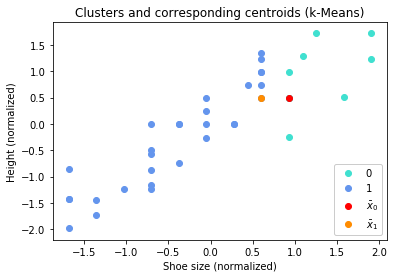

29 points moved this round. Optimization continues.


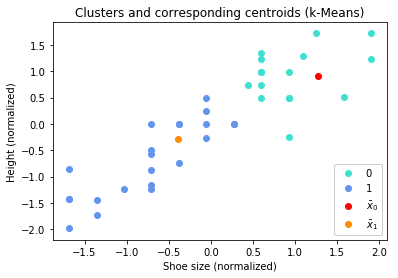

7 points moved this round. Optimization continues.


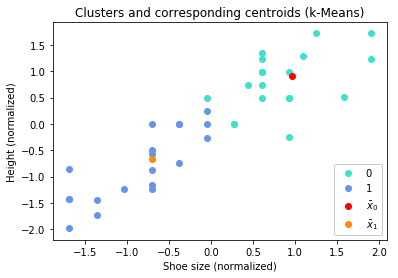

3 points moved this round. Optimization continues.


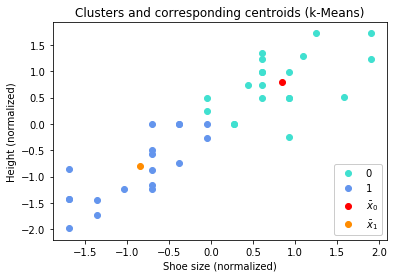

1 point moved this round. Optimization continues.


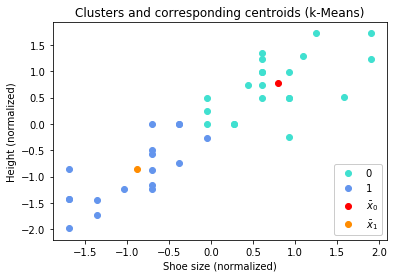

1 point moved this round. Optimization continues.


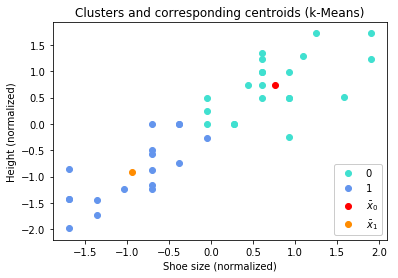

0 points moved this round. Optimization will stop.

Algorithm needed 6 iterations until convergence.


In [8]:
# init k-Means with 2 clusters
kMeans = KMeans(random_state=42, n_clusters=2,method='k-means')
normalized_data_kMeans, means_optim = kMeans.fit_predict(normalized_data, epochs = 10) #%timeit 

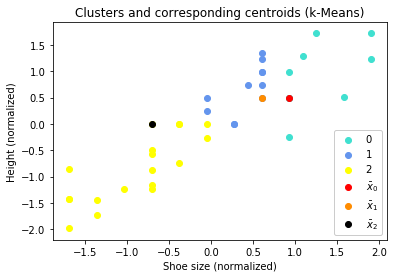

29 points moved this round. Optimization continues.


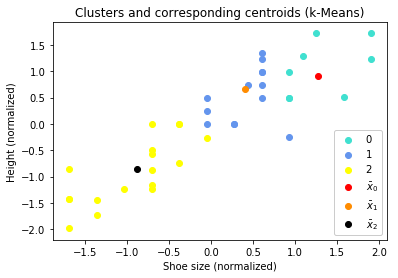

2 points moved this round. Optimization continues.


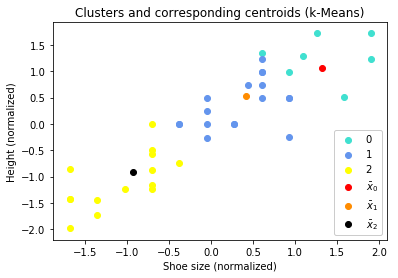

6 points moved this round. Optimization continues.


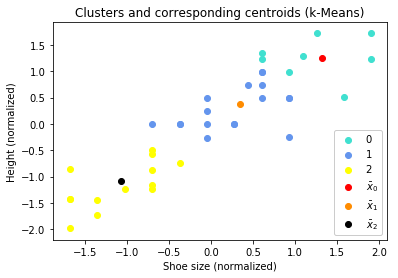

2 points moved this round. Optimization continues.


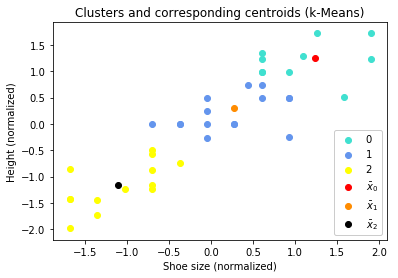

2 points moved this round. Optimization continues.


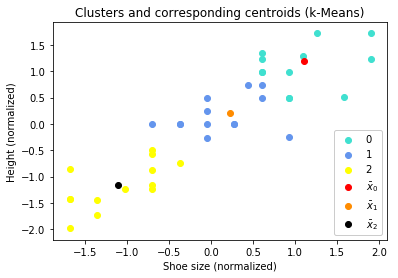

2 points moved this round. Optimization continues.


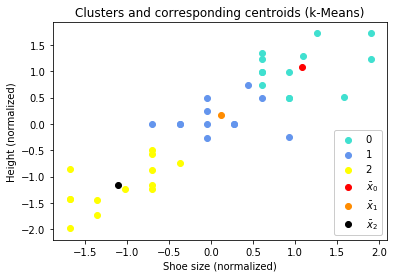

1 point moved this round. Optimization continues.


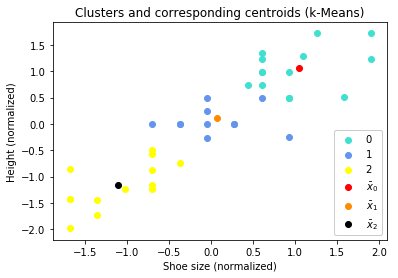

1 point moved this round. Optimization continues.


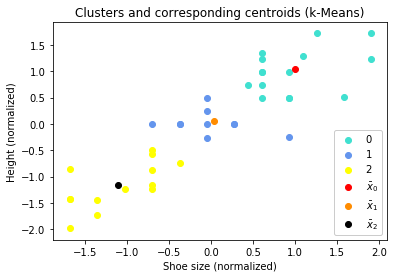

1 point moved this round. Optimization continues.


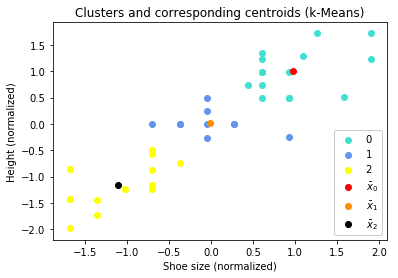

0 points moved this round. Optimization will stop.

Algorithm needed 10 iterations until convergence.


In [9]:
# init k-Means with 3 clusters 
kMeans = KMeans(random_state=42, n_clusters = 3,method='k-means')
normalized_data_kMeans, means_optim = kMeans.fit_predict(normalized_data, epochs = 10) #%timeit 

### k-Medoids

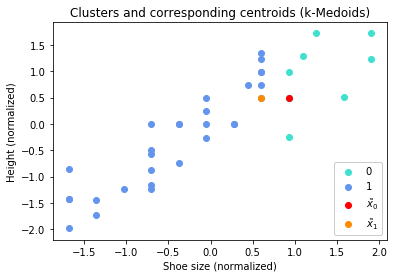

21 points moved this round. Optimization continues.


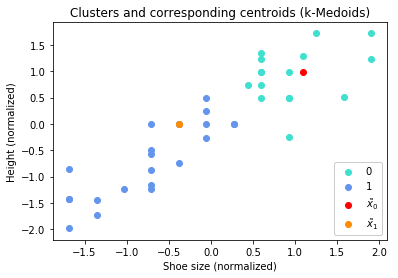

7 points moved this round. Optimization continues.


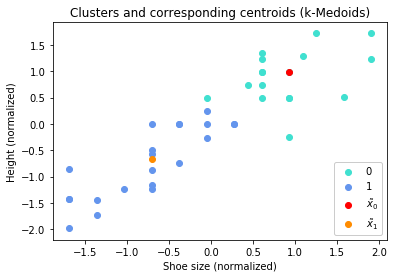

1 point moved this round. Optimization continues.


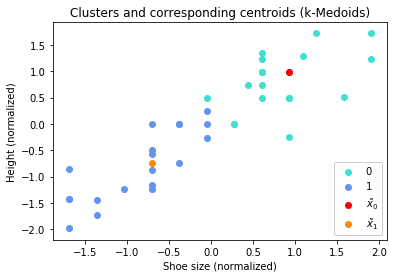

2 points moved this round. Optimization continues.


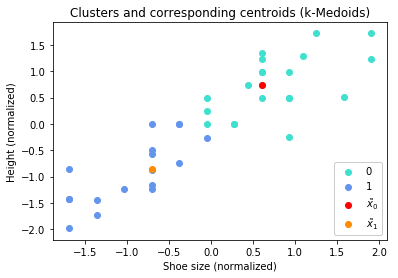

2 points moved this round. Optimization continues.


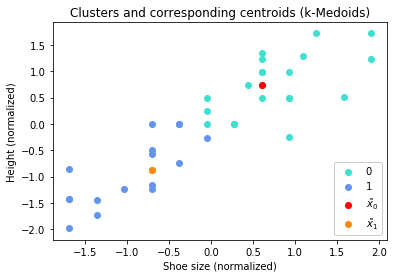

0 points moved this round. Optimization will stop.

Algorithm needed 6 iterations until convergence.


In [10]:
# init k-Medoids with 2 clusters
kMedoids = KMeans(random_state=42, n_clusters=2, method='k-medoids')
normalized_data_kMedoids, means_optim = kMedoids.fit_predict(normalized_data, epochs = 10) #%timeit 

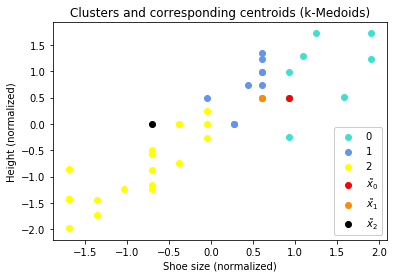

29 points moved this round. Optimization continues.


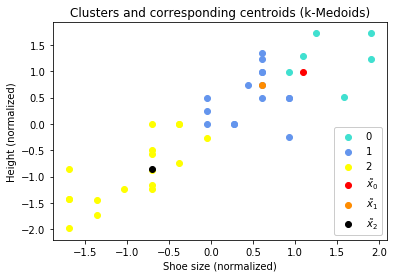

5 points moved this round. Optimization continues.


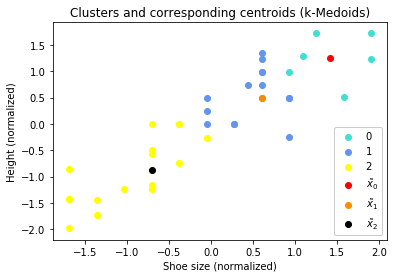

0 points moved this round. Optimization will stop.

Algorithm needed 3 iterations until convergence.


In [11]:
# init k-Medoids with 3 clusters
kMedoids = KMeans(random_state=42, n_clusters=3, method='k-medoids')
normalized_data_kMedoids, means_optim = kMedoids.fit_predict(normalized_data, epochs = 10) #%timeit 

## Get data ready for classification

In [12]:
# normalize strings in study_programme column to use them as keys in a dictionary
# keep capitalization for MSc, as MSc shall be distinguished from the rest of the string as a noun
data.study_programme = data.study_programme.apply(lambda string: re.sub(' ', '_', string.strip(', ITU')).capitalize())

# normalize sentences (remove punctuation and lower case all words)
data.motivation = data.motivation.apply(lambda sent: re.sub('[^\w\s]', '', sent).lower())

# add column with number of words students used to describe their motivation for taking the course
# NOTE: we cannot use attribute method here, we have to key-index the dataframe
data['n_words_used'] = data.motivation.apply(lambda sent: len(sent.split()))

In [13]:
data_to_classify = data.loc[:, ['motivation', 'study_programme']]

### Train Naive Bayes algorithm

In [14]:
# since our data set is incredibly small, let's just use approx. 10% of the data as our test set and 90% for training
n_samples = len(data_to_classify)
n_test_samples = math.ceil(n_samples / 10)

# pick random data examples as our held out test set
test_indices = random.sample(list(range(0, n_samples-1)), k = n_test_samples)
train_indices = [idx for idx in range(0, n_samples) if idx not in test_indices]
assert len(test_indices) == n_test_samples

# create train and test sets
train_set = data_to_classify.iloc[train_indices]
test_set = data_to_classify.iloc[test_indices]
X_test, y_test = test_set.motivation.values, test_set.study_programme.values

In [15]:
# First approach
clf = NaiveBayes(method='count')
counts_per_class = clf.train(train_set)

In [16]:
# Second approach

#clf = NaiveBayes(method='cond_proba')
#cond_probas_per_class = clf.train(data_to_classify)

### Evaluate Naive Bayes algorithm  on held out test set

In [19]:
y_hat = np.array([clf.predict_proba(counts_per_class, test_sent) for test_sent in X_test])
print("Weighted f1-score of Naive Bayes on held out test set: {}".format(round(f1_score(y_test, y_hat, average='weighted'), 3)))
print("Accuracy of Naive Bayes on held out test set: {}".format(accuracy_score(y_test, y_hat)))

Weighted f1-score of Naive Bayes on held out test set: 0.375
Accuracy of Naive Bayes on held out test set: 0.25


### Type your own sentence to see to which study programme you belong according to Naive Bayes

In [18]:
print("Why are you taking the course Data Mining?")
print()
test_sent = str(input())
print()
y_pred = clf.predict_proba(counts_per_class, test_sent)
print("You're most probably from the study programme {}".format(y_pred))

Why are you taking the course Data Mining?

Hello world

You're most probably from the study programme Msc_digital_innovation_and_management
